# Gaussian Random Fields

See:
* [Random fields and geometry: Adler](https://www.springer.com/us/book/9780387481128)
* [lecture notes by Eiichiro Komatsu](https://wwwmpa.mpa-garching.mpg.de/~komatsu/cmb/lecture_NG_iucaa_2011.pdf)
* http://www.astro.rug.nl/~weygaert/tim1publication/lss2007/computerIII.pdf
* http://www.ib.pwr.wroc.pl/wpula/w14.pdf

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import GPy
%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Definitions and basic examples.

A "random field" is just a "stochastic process" (where "random" -> "stochastic" and "field" -> "process"). [Wikipedia](https://en.wikipedia.org/wiki/Random_field) has a really nice simple summary:

> At its most basic, discrete case, a random field is a list of random numbers whose indices are identified with a discrete set of points in a space (for example, n-dimensional Euclidean space). When used in the natural sciences, values in a random field are often spatially correlated in one way or another. In its most basic form this might mean that adjacent values (i.e. values with adjacent indices) do not differ as much as values that are further apart. This is an example of a covariance structure.

All a random field or process is, is a **list of random numbers**. We will encounter fields with properties that govern the relationships between those numbers, but this is not a complicated idea.

Let's generate a couple of fields and see what they look like.

## Uncorrelated random fields 

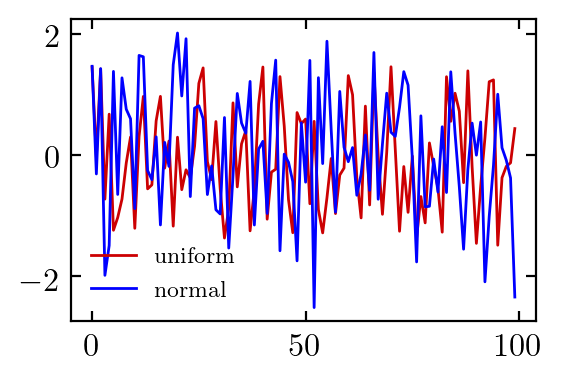

In [15]:
n = 100

_, ax = plt.subplots(figsize=mpl.small_plotsize)
ax.plot(3*(np.random.uniform(size=n)-0.5), label="uniform")
ax.plot(np.random.normal(size=n), label="normal")
ax.legend(fontsize="xx-small")

## Correlated (gaussian) random fields

If we are trying to model something physical, let's say the temperature in a room, the random numbers are not going to be uncorrelated. In this case, the adjacent numbers are going to be very similar. We therefore need someway to encode that correlation.

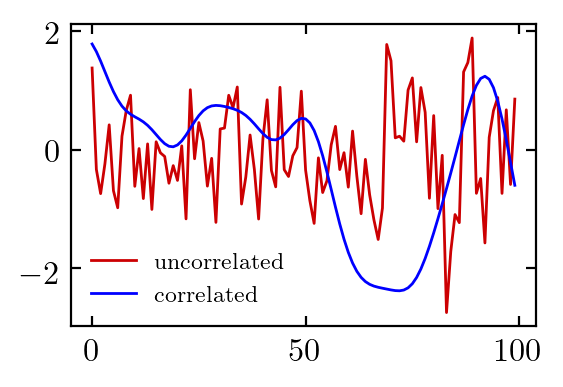

In [37]:
n = 100
_, ax = plt.subplots(figsize=mpl.small_plotsize)

# Uncorrelated
pts = np.random.multivariate_normal(np.zeros(n), np.diag(np.ones(n)))
ax.plot(pts, label="uncorrelated")

# Correlated
dist_between_pts = np.arange(n)[np.newaxis,:] - np.arange(n)[:,np.newaxis]
length_scale = 10
# I use the RBF kernel for my correlation function. No real reason for this... It is easy to implement and understand
cov_matrix = np.exp(-np.power(dist_between_pts/length_scale, 2))
pts = np.random.multivariate_normal(np.zeros(n), cov_matrix)
ax.plot(pts, label="correlated")

ax.legend(fontsize="xx-small")

## Correlated (markov) random fields

Think of this as a weather model - tomorrow is x% likely to be the same as today.

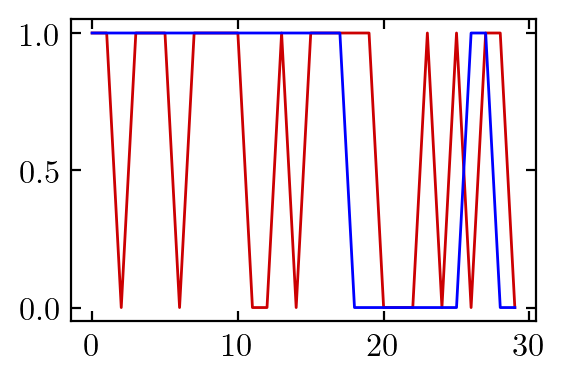

In [48]:
n = 30
_, ax = plt.subplots(figsize=mpl.small_plotsize)

# Uncorrelated
pts = np.random.randint(0, 2, size=n)
ax.plot(pts, label="uncorrelated")

pts = [1]
prob_same = 0.9
for i in range(n - 1):
    pts.append(pts[-1] if np.random.random() < prob_same else abs(pts[-1] - 1))
ax.plot(pts, label="correlated")

# Formalism

Don't you love it when math textbooks (ahem Adler) say things like:

> Here is a formal definition, which states the obvious (and, we hope, the familiar). 
>
> Let $(\Omega, \mathcal{F}, \mathbb{P})$ be a complete probability space and $T$ a topological space. Then a measurable mapping $f : \Omega \rightarrow \mathbb{R}^T$
(the space of all real-valued functions on T) is called a real-valued random field.

Well no, unfortunately that is neither obvious, nor familiar to me...

Resorting to [wikipedia](https://en.wikipedia.org/wiki/Probability_space) (again), we learn that $(\Omega, \mathcal{F}, \mathbb{P})$ is a **probability space**. The components are,
* $\Omega$: the set of all possible outcomes (a sample space)
* $\mathcal{F}$: the set of events that we care about, where each event is a set containing zero or more outcomes (a subset of the sample space)
* $\mathbb{P}$: the probability of a given event

This doesn't make much sense, but it will if we give a concrete example. Let's say we roll a single die and we  care whether the roll is odd, even, one, or greater than 10. Then,
* $\Omega = \{1, 2, 3, 4, 5, 6\}$.
* $\mathcal{F} = \{
{\rm odd}: \{1, 3, 5\}, 
{\rm even}: \{2, 4, 6\}, 
{\rm one}: \{1\}, 
{\rm gt\_ten}: \{\}\}$
* $\mathbb{P} = \{
{\rm odd}: 0.5, 
{\rm even}: 0.5,
{\rm one}: 0.166, 
{\rm gt\_ten}: 0\}$

Ok, sweet. We can now define our [random field](https://en.wikipedia.org/wiki/Random_field) $F$ (note that this is a different $F$ to $\mathcal{F}$!) over the topological space $T$. It is just the set, $\{F_t: t \in T\}$ where each $F_t$ is a draw from the probability space (I'm not sure whether it is an outcome or an event...)

This was somewhat interesting, but I'm not yet sure why it is useful... Most of it is still going well over my head.

# Generating GRF

I've already shown one way to generate GRF. You explicitly define the mean vector and covariance matrix and draw from the multivariate normal. This doesn't scale to large numbers of points though ($n^2$ storage needed for the covariance matrix).

# Original attempts

## Covariance Matrix

Imagine a single variable with a centered (mean of 0) Gaussian PDF

$$
P(x) = \frac{1}{2 \pi \sigma^{2}}\ \text{exp}({\frac{-x^2}{2 \sigma^2}})
$$

This can be generalized to a multivariable gaussian with

$$
P(x_1, x_2, ..., x_n) = \frac{1}{(2 \pi) ^ {n/2} |\Sigma|^{1/2}} 
$$

where $\Sigma$ is the covariance matrix for $\vec{x}$. $\Sigma_{i,j} =\ <x_i x_j>$ (this works as this is centered!)


... Insert the math here (isotropy, homogeneity) ...

Therefore the covariance between two points is a function only of the distance between them.

$$
\Sigma_{i, j} = f(|\vec{r_{i, j}}|
$$

In [141]:
size = 50
area = size ** 2
cov = area ** 2

l, lT = np.arange(area), (np.expand_dims(np.arange(area), 1))
r = np.sqrt(
    np.power(l % size - lT % size, 2) + 
    np.power(l // size - lT // size, 2)
)
var, ls = 1, 3
cov_func = lambda r: var * np.exp(-np.power(r/ls, 2))

cov = cov_func(r)

### Sanity cov

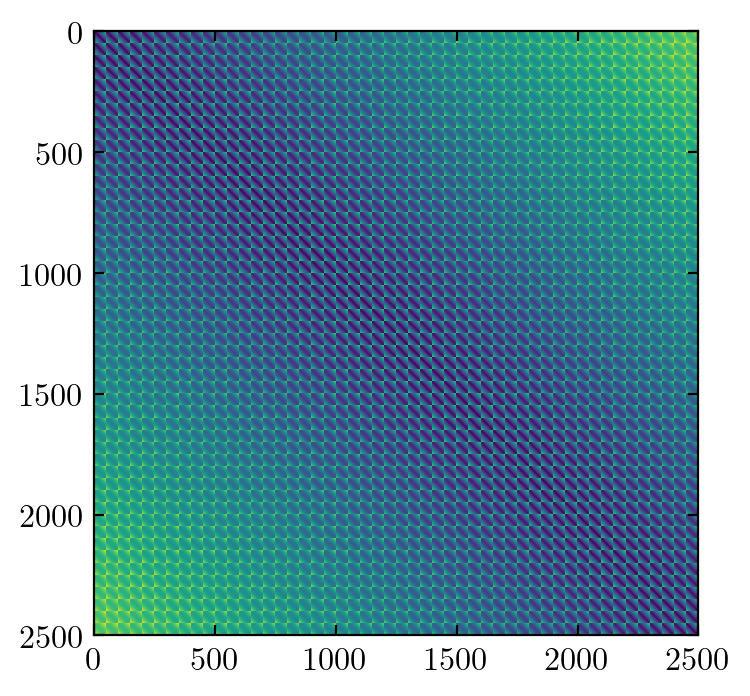

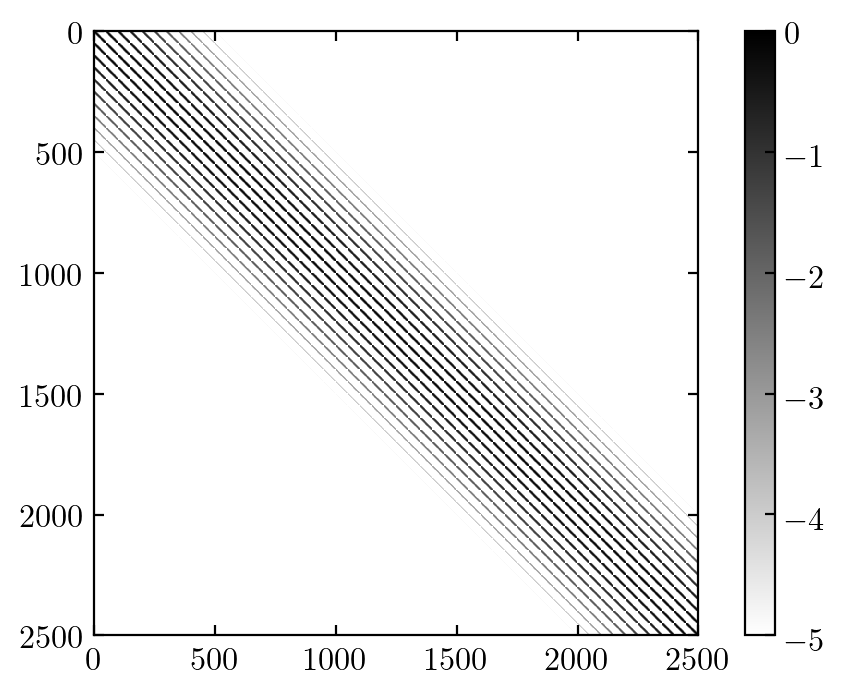

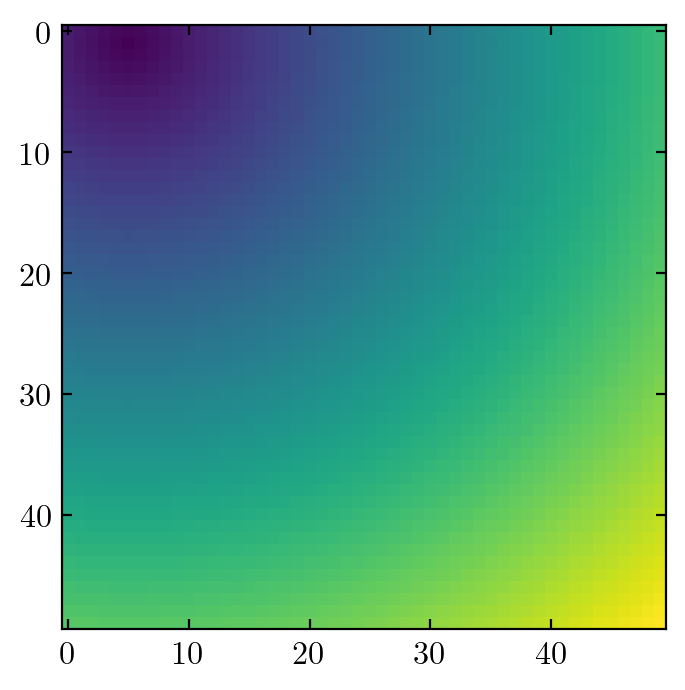

In [145]:
_, ax = plt.subplots()
ax.imshow(r)

_, ax = plt.subplots()
img = ax.imshow(np.log10(np.maximum(cov, 1e-5)), cmap="binary")
plt.colorbar(img)

_, ax = plt.subplots()
ax.imshow(r[55].reshape((size, size)))

### GRF

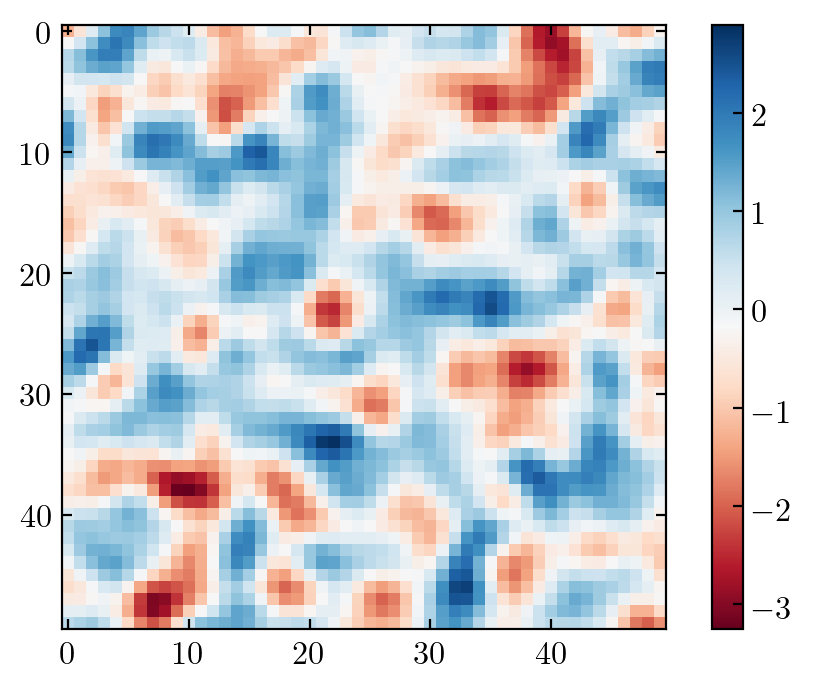

In [111]:
d = np.zeros(area)
d = np.random.multivariate_normal(np.zeros(area), cov)
_, ax = plt.subplots()

img = ax.imshow(d.reshape((size, size)), cmap="RdBu")
plt.colorbar(img)

## FFT

In [160]:
print(fftIndgen(100))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


TypeError: Image data cannot be converted to float

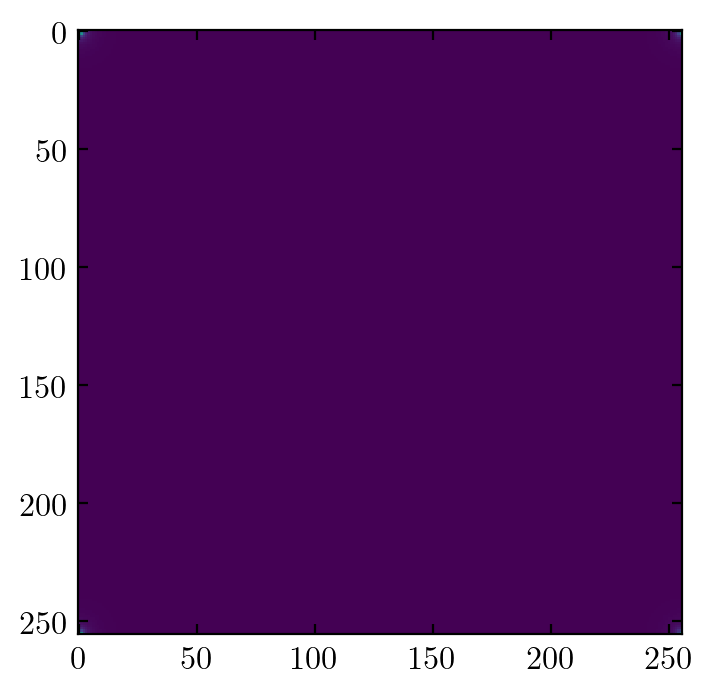

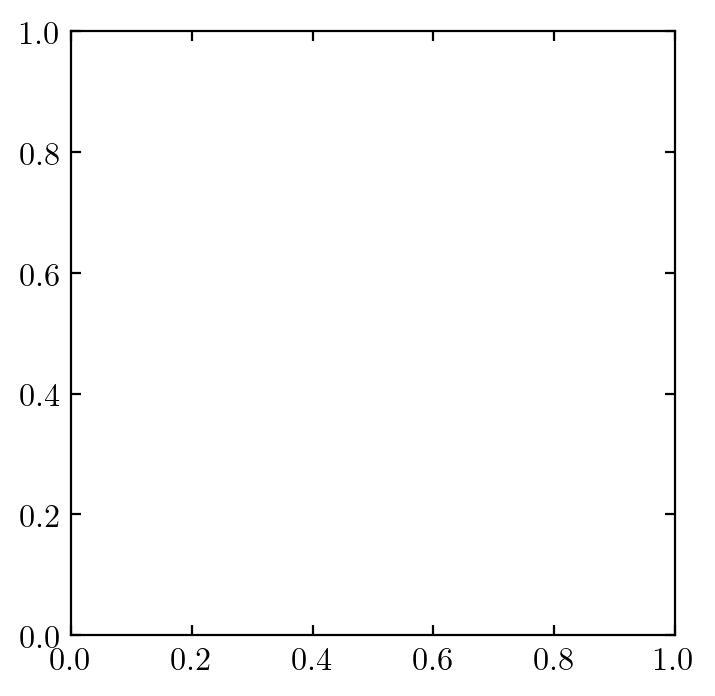

In [173]:
def fftIndgen(n):
    a = list(range(0, int(n/2+1)))
    b = list(range(-int(n/2-1), 0))
    return a + b

def gaussian_random_field(Pk = lambda k : k**-3.0, size = 100):
    def Pk2(kx, ky):
        if kx == 0 and ky == 0:
            return 0.0
        return np.sqrt(Pk(np.sqrt(kx**2 + ky**2)))
    noise = np.fft.fft2(np.random.normal(size = (size, size)))
    amplitude = np.zeros((size,size))
    
    
    for i, kx in enumerate(fftIndgen(size)):
        for j, ky in enumerate(fftIndgen(size)):            
            amplitude[i, j] = Pk2(kx, ky)
            
    _, ax = plt.subplots()
    ax.imshow(amplitude)
    import pdb
    _, ax = plt.subplots()
    ax.imshow(noise)
    
    return np.fft.ifft2(amplitude * noise)

for alpha in [-4]:# [-4.0, -3.0, -2.0]:
    out = gaussian_random_field(Pk = lambda k: k**alpha, size=256)
    _, ax = plt.subplots()
    ax.imshow(out.real, interpolation='none')

[[-199.13769999  +0.j          -31.12477313 -33.36658673j -105.04995663 +86.94202495j ... -165.67464169 -91.21829806j -105.04995663 -86.94202495j  -31.12477313 +33.36658673j]
 [  69.47888252  +1.05525231j   62.93290263+313.36768229j  135.55157431+112.83234438j ...  288.6294186  -14.95478137j  -19.51311784+428.21936224j   17.40048898 -92.89625692j]
 [-449.57616144 -14.7698976j    43.62984652-253.09860098j   90.3145577  -37.12563079j ...  -71.42718823  -0.92063418j  201.82562356 +50.0375255j   -22.138172   +51.57819361j]
 ...
 [  60.91580287 +67.99453695j  255.23989293-102.57196313j  -20.79868467+265.04228307j ...  319.78470255 +64.75181315j -178.39369415+112.92952311j -164.85369988 -33.39673219j]
 [-449.57616144 +14.7698976j   -22.138172   -51.57819361j  201.82562356 -50.0375255j  ...  165.78612643-117.8700018j    90.3145577  +37.12563079j   43.62984652+253.09860098j]
 [  69.47888252  -1.05525231j   17.40048898 +92.89625692j  -19.51311784-428.21936224j ... -174.85228245-123.91901444j  1

TypeError: Image data cannot be converted to float

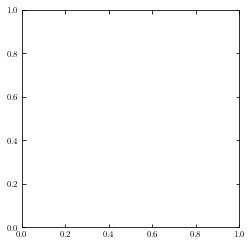

In [8]:
size = 256
np.random.seed(12)
noise_config_space = np.random.normal(size = (size, size))
noise = np.fft.fft2(noise_config_space)
print(noise)
print(noise_config_space)

_, ax = plt.subplots()
ax.imshow(noise)